In [1]:
import numpy as np
from project import Phase
import torch
import sys
from matplotlib import pyplot as plt

constants = {}
constants['progress'] = False
constants['c'] = 1.42
constants['Aeff'] = 7.29
constants['t_final'] = 300
constants['sim_method'] = 'discrete'
constants['ul_coord'] = [1500, 2800]
constants['lr_coord'] = [2723, 3905]
'''Should just set this to min tau_vec I think, which it basically already is'''
constants['min_tau'] = 2
constants['A_cell'] = 270**2 / 1e6 #km^2
constants['ncell_min'] = 2_500
constants['root'] = 0 #For mpi
constants.update({'final_max_tau': np.nan})
constants['meta_metric'] = 'gte_thresh'
constants.update({'metric': 'lambda_s'})
constants.update({'tauc_method': 'flat'})
constants.update({'overwrite_metrics': False}) 
constants['overwrite_results'] = False

pproc = Phase(**constants)
pproc.initialize()
assert pproc.metric_exp_spl(pproc.min_tau) > 0

[Mac.search.charter.net:81873] shmem: mmap: an error occurred while determining whether or not /var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T//ompi.Mac.501/jf.0/3939696640/sm_segment.Mac.501.ead30000.0 could be created.
/Users/patrick/Research/Regan/TecateCypress/sensitivity/project.py:371: RuntimeWarning: divide by zero encountered in divide
  b_raster = delta_t / np.power(-np.log(1-fdm), 1/self.c)


#### Training data generation

0.986930292384002

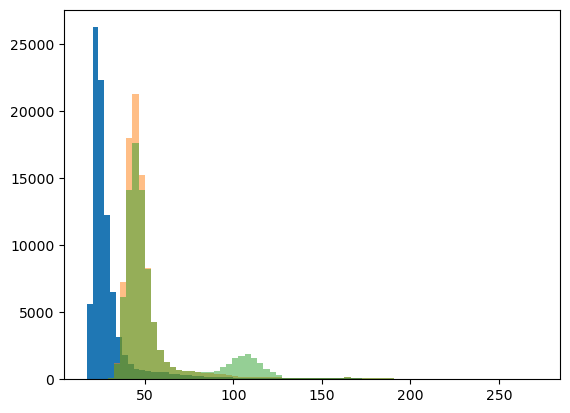

In [2]:
plt.hist(pproc.tau_flat, bins=70);
pproc.mu_tau = 20
pproc.sigm_tau = 3
pproc.generate_eps_tau(pproc.mu_tau, pproc.sigm_tau)
pproc.tau_expect = pproc.tau_flat + pproc.eps_tau
plt.hist(pproc.tau_expect, bins=70, alpha=0.5);

pproc.mu_tauc = 20
pproc.sigm_tauc = 8
pproc.change_tau_expect(5*pproc.ncell_tot, 10_000, 20_000)
plt.hist(pproc.tau_expect, bins=70, alpha=0.5);

pproc.calculate_metric_expect()
pproc.metric_expect

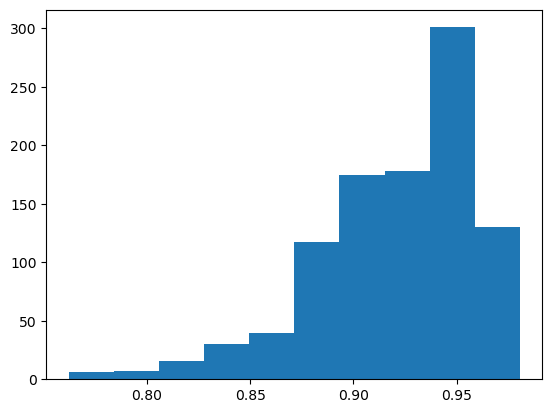

In [2]:
#### Get samples of each parameter we want to train on ####
NUM_TRAIN = 1000

# Function to return parameter combinations as dicts
def product_dict(**kwargs):
    keys = kwargs.keys()
    for instance in itertools.product(*kwargs.values()):
        yield dict(zip(keys, instance))

# For sampling from various probability distributions
rng = np.random.default_rng()

# Theoretical (or ad-hoc) maxima/minima for parameters
minima = {
    'C': 5.*pproc.ncell_tot,
    'ncell': int(0.02*pproc.ncell_tot), 
    # 'ncell': int(pproc.ncell_tot - pproc.slice_right_max),
    'slice_left': int(0.* pproc.ncell_tot),
    'mu_tau': -10.,
    'sigm_tau': 0.,
    'mu_tauc': -10.,
    'sigm_tauc': 0.
}
maxima = {
    'C': 5.*pproc.ncell_tot,
    'ncell': int(1. * pproc.slice_right_max), 
    'slice_left': int(1.*pproc.ncell_tot),
    'mu_tau': 6.,
    'sigm_tau': 10.,
    'mu_tauc': 6.,
    'sigm_tauc': 10.
}
param_keys = np.array(list(minima.keys()))

# Generate parameter values for training
train_x = np.full((NUM_TRAIN, len(minima)), np.nan)
for param_i, ((key1, _min), (key2, _max)) in enumerate(zip(minima.items(), maxima.items())):
    assert(key1 == key2); key = key1 = key2
    
    try:
        assert (type(_min)==type(_min))
        _type = type(_min)
    except:
        print('hey thats bad', type(_min), type(_min)); sys.exit()
        
    # Skip slice_left for now, sample after ncell has been sampled
    if key == 'slice_left': continue 
    
    if _type == float:
        param_samples = rng.uniform(_min, _max, len(train_x))
    elif _type == int:
        param_samples = rng.integers(_min, _max, len(train_x))
    train_x[:, param_i] = param_samples
# Sample slice_left only where feasible given ncell samples
ncell_column = np.nonzero(param_keys == 'ncell')[0][0]
slice_left_max_vec = pproc.slice_right_max - train_x[:,ncell_column]
slice_left_column = np.nonzero(param_keys == 'slice_left')[0][0]
train_x[:, slice_left_column] = rng.uniform(0, slice_left_max_vec)

    
# Generate metric values for training
train_y = np.full((len(train_x), 1), np.nan)
for x_i, x in enumerate(train_x):
    for i, param in enumerate(param_keys):
        # Assign parameter values for this sample
        setattr(pproc, param, x[i].astype(type(minima[param])))
        
    if pproc.slice_left > (pproc.slice_right_max - pproc.ncell):
        continue # Skip bc slice start too high
        
    # Reset tau values to baseline
    pproc.tau_expect = pproc.tau_flat

    # Add in uncertainty on baseline tau values
    pproc.generate_eps_tau(pproc.mu_tau, pproc.sigm_tau)
    pproc.tau_expect = pproc.tau_flat + pproc.eps_tau

    # Shift selected tau values (including uncertainty)
    pproc.change_tau_expect(pproc.C, pproc.ncell, pproc.slice_left)
    
    # Compute and store metric value
    pproc.calculate_metric_expect()
    train_y[x_i] = pproc.metric_expect
plt.show()
plt.hist(train_y);

#### Training

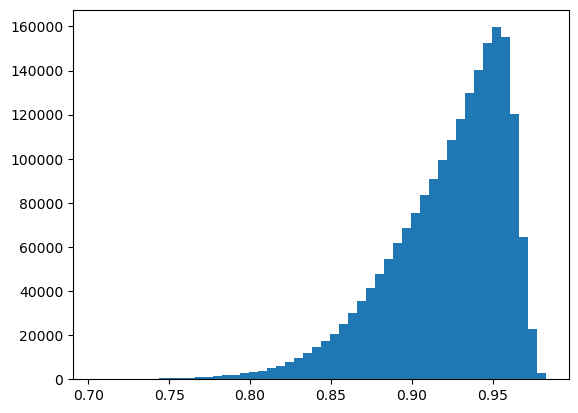

In [2]:
train_x = np.load('train_x.npy')
train_y = np.load('train_y.npy')
plt.hist(train_y, bins=50);

In [11]:
from NN_testing.NN_deterministic import *
from NN_testing.EarlyStopping import EarlyStopping
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import timeit

torch.set_num_threads(torch.get_num_threads())

# BATCH_SIZE = 1024  # Tune this depending on your memory (try 64–1024)
# BATCH_SIZE = 2_048
BATCH_SIZE = 312  
# BATCH_SIZE = 64
PENALTY_WEIGHT = 1e-12
COMPLEXITY_COST_WEIGHT = None
PATIENCE = 100
SAMPLE_NBR = 1
NUM_EPOCHS = 6000
HIDDEN_DIM = 50

full_x = np.load('train_x.npy')
full_y = np.load('train_y.npy')
full_x = torch.from_numpy(full_x).float()
full_y = torch.from_numpy(full_y).float()

# Drop the first column of inputs because we're keeping them constant for now (total resources)
full_x = full_x[:, 1:]

# Select a smaller slice of all generated data to use for training
NUM_TRAIN = 200_000
train_x = full_x[:NUM_TRAIN, :]
train_y = full_y[:NUM_TRAIN, :]

train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y, test_size=0.1, random_state=42
)

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=False, num_workers=0)

val_dataset = TensorDataset(val_x, val_y)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=False, num_workers=0)

In [12]:
for batch_x, batch_y in train_loader:
    print(batch_x.shape)
    break

torch.Size([312, 6])


In [19]:
from tqdm import tqdm
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"

model = NN(input_dim=train_x.shape[1], hidden_dim = HIDDEN_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=1e-6)

start_time = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS)):
    epoch_start = timeit.default_timer()
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        train_loss = loss_fn(model, batch_x, batch_y, sample_nbr=SAMPLE_NBR, 
                             complexity_cost_weight=COMPLEXITY_COST_WEIGHT,
                             penalty_weight=PENALTY_WEIGHT)
        train_loss.backward()
        optimizer.step()
        epoch_loss += train_loss.item() * batch_x.size(0)  # Accumulate total loss

    epoch_loss /= len(train_dataset)  # Average over the full dataset
    
    # Validation step
    epoch_val_loss = 0.0
    for batch_x, batch_y in val_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        model.eval()
        with torch.no_grad():
            val_loss = loss_fn(model, batch_x, batch_y, sample_nbr=SAMPLE_NBR,
                               complexity_cost_weight=COMPLEXITY_COST_WEIGHT,
                               penalty_weight=PENALTY_WEIGHT)
        epoch_val_loss += val_loss.item() * batch_x.size(0)
    epoch_val_loss /= len(val_dataset)

    early_stopper(epoch_val_loss, model)
    if early_stopper.early_stop:
        print(f"Early stopping at epoch {epoch}")
        print(f"Epoch {epoch}: Epoch loss = {epoch_loss:.4f} | Val Loss = {val_loss.item():.4f}")
        break
        
    if epoch % (NUM_EPOCHS // 20) == 0:
        # print(f"Epoch {epoch}: Epoch loss = {epoch_loss:.4f} | Val Loss = {val_loss.item():.4f}")
        print(f"Epoch {epoch}: Epoch loss = {epoch_loss:.4f}")
    
    # print(f"{timeit.default_timer() - epoch_start} seconds")

  0%|                                        | 1/6000 [00:02<3:58:41,  2.39s/it]

Epoch 0: Epoch loss = 52.3077


  0%|                                        | 2/6000 [00:06<5:30:50,  3.31s/it]


KeyboardInterrupt: 

In [5]:
print(torch.cuda.is_available())  # Always False on M2 Macs
print(torch.backends.mps.is_available())  # True if MPS (Metal Performance Shaders) is available

False
True


In [6]:
model

NN(
  (fc1): Linear(in_features=6, out_features=50, bias=True)
  (relu): ReLU()
  (out_mean): Linear(in_features=50, out_features=1, bias=True)
  (out_var): Linear(in_features=50, out_features=1, bias=True)
)

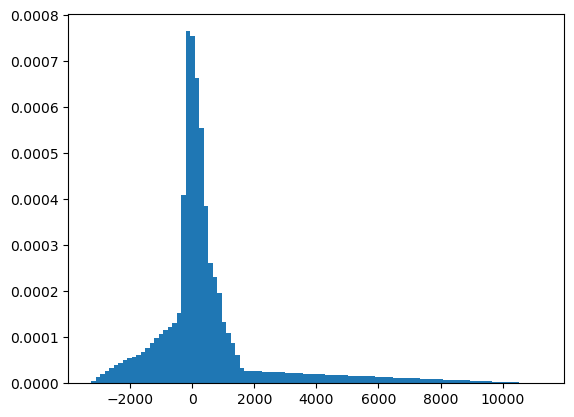

In [10]:
with torch.no_grad():
    test_x = full_x[NUM_TRAIN:,:]
    test_y = full_y[NUM_TRAIN:,:]

    pred_means, pred_vars = model(test_x)
    plt.hist(pred_means, density=True, bins=100);
    # plt.hist(test_y, density=True);